<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изучение данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Регрессии-с-регуляризацией." data-toc-modified-id="Регрессии-с-регуляризацией.-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Регрессии с регуляризацией.</a></span><ul class="toc-item"><li><span><a href="#Lasso-(L1-регуляризация)." data-toc-modified-id="Lasso-(L1-регуляризация).-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Lasso (L1 регуляризация).</a></span></li><li><span><a href="#Ridge-(L2-регуляризация)." data-toc-modified-id="Ridge-(L2-регуляризация).-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Ridge (L2 регуляризация).</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Временные ряды
# Проект "Прогнозирование заказов такси"
# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час и построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Ход выполнения работы:**  
- 1. Подготовка Данных  
- 2. Анализ данных  
- 3. Обучение моделей
- 4. Тестирование моделей  
- 5. Выводы  

## Подготовка
### Изучение данных
Импортируем необходимые инструменты.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

Загрузим данные.

In [2]:
try:    
    frame = pd.read_csv('D:/notebook/project_12/taxi.csv', index_col='datetime', parse_dates=[0]) 
except: 
    frame = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [3]:
frame

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]

# Описание данных

 - Столбец `datetime` преобразован в индекс датафрейма, обозначающий отметку по дате и времени.
 - Столбец `num_orders` (от англ. *number of orders*) обозначает число заказов.
 
Проверим информацию о датафрейме.

In [4]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В датафреме история количества заказов за временной отрезок с `1 марта по 31 августа 2018 года`, `26496 строк`, `1` столбец, число заказов отражены целочисленным  типом данных `int64`.

Преобразуем типы данных в столбце `'num_orders'` для экономии места.

In [5]:
frame.num_orders = pd.to_numeric(frame.num_orders, downcast='integer')
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int8 
dtypes: int8(1)
memory usage: 232.9 KB


Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим на атрибут индекса таблицы is_monotonic (англ. «монотонный»). Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [6]:
print(frame.index.is_monotonic)

True


Сортировка индекса не требуется.

Выполним ресемплирование данных по часу. Для отображения суммы заказов за час - агрегировать будем функцией `sum()`.

In [7]:
frame = frame.resample('1H').sum()

Посмотрим новый временной промежуток.

In [8]:
print(frame.index.min(),'-', frame.index.max())

2018-03-01 00:00:00 - 2018-08-31 23:00:00


Ресемплирование прошло корректно.

## Анализ

Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики последнего месяца временного ряда и проанализируем данные.

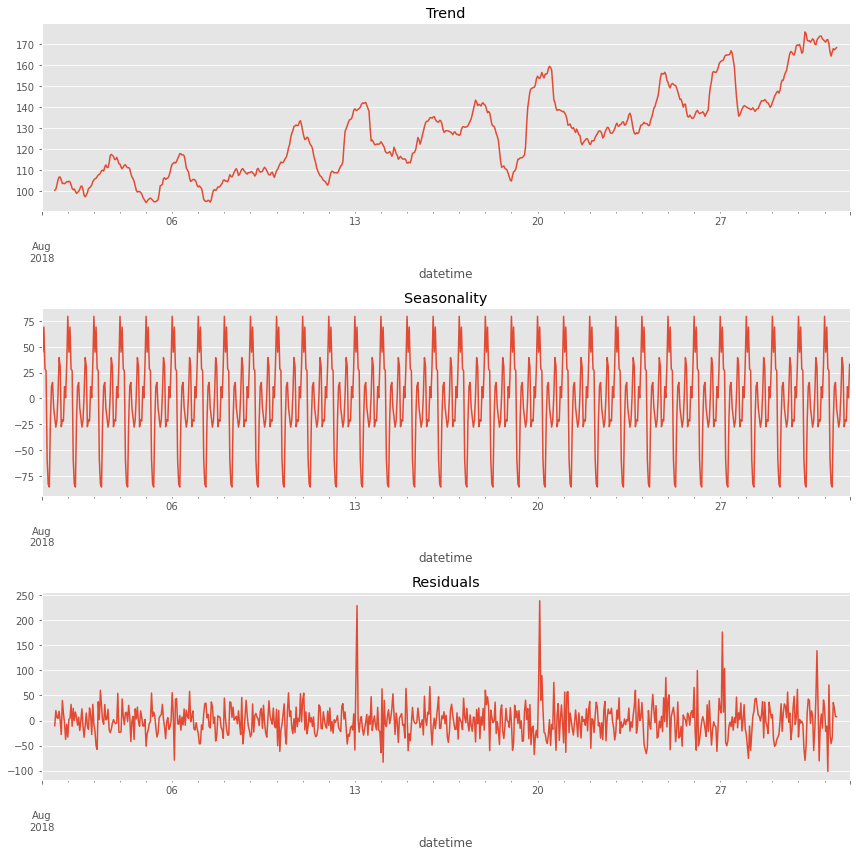

In [38]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(frame['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

- Трэнд показывает линейный рост количества заказов со временем. 
- Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
- Остаток декомпозиции также имеет постоянной среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам)


Построим тренд для всего временного ряда, чтобы увидеть полную картину.

Text(0.5, 1.0, 'Trend')

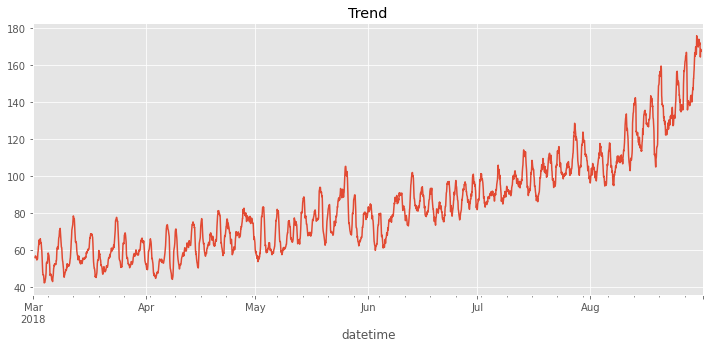

In [44]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(frame)
plt.figure(figsize=(12, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

- Трэнд имеет более сложную зависимость от времени. Для нашей задачи будем считать его линейным (предсказания нам нужны всего на час вперёд).
- Линия тренда имеет некоторый шум. Для предсказания необходимо применить скользящее среднее с окном в несколько десятков часов.

## Обучение

Для baseline модели предскажем новые значения по медиане и предыдущим значением.

Разобьем выборки на обучающую и тестовую.

In [11]:
train, test = train_test_split(frame, shuffle=False, test_size=0.1)

Посмотрим границы обучающей и тестовой выборок.

In [12]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Проверим предсказания по медианному значению.

In [13]:
pred_median = np.ones(test.shape) * train['num_orders'].median()
print("RMSE baseline модели:", round(mean_squared_error(test['num_orders'], pred_median) ** 0.5,3))

RMSE baseline модели: 87.153


Проверим предсказания предыдущим значением ряда.

In [14]:
pred_previous = test.shift(fill_value=train.iloc[-1]['num_orders'])
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE baseline модели:", round((rmse_base), 3))

RMSE baseline модели: 58.856


Предсказания по предыдущему значению показывают лучший результат. Возьмём их в качестве baseline.

Создадим функцию для создания обучающих признаков. Добавим признаки `day`, `dayofweek`, признаки отстающего значения `lag_i` и признаки для скользящего среднего `rolling_mean` (с размером окна `rolling_mean_size`).

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df ['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [16]:
df = make_features(frame, 30, 50)

### Линейная регрессия
Обучим линейную регрессию. Разделим данные в соотношении 9:1 (10% тестовой выборки).

In [17]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [18]:
train

num_orders  dayofweek  lag_1  lag_2  lag_3  lag_4  lag_5  \
datetime                                                                        
2018-03-03 02:00:00        25.0          5  108.0  163.0   72.0  119.0  101.0   
2018-03-03 03:00:00        64.0          5   25.0  108.0  163.0   72.0  119.0   
2018-03-03 04:00:00        44.0          5   64.0   25.0  108.0  163.0   72.0   
2018-03-03 05:00:00        15.0          5   44.0   64.0   25.0  108.0  163.0   
2018-03-03 06:00:00         9.0          5   15.0   44.0   64.0   25.0  108.0   
...                         ...        ...    ...    ...    ...    ...    ...   
2018-08-13 09:00:00       137.0          0   91.0   39.0   66.0   83.0  143.0   
2018-08-13 10:00:00       156.0          0  137.0   91.0   39.0   66.0   83.0   
2018-08-13 11:00:00       144.0          0  156.0  137.0   91.0   39.0   66.0   
2018-08-13 12:00:00        92.0          0  144.0  156.0  137.0   91.0   39.0   
2018-08-13 13:00:00       119.0          0   92.0  144.0  156.0  137.0   91.0   

                     lag_6  lag_7  lag_8  ...  lag_22  lag_23  lag_24  lag_25  \
datetime                                  ...                                   
2018-03-03 02:00:00   93.0   49.0   89.0  ...    20.0    64.0    75.0   120.0   
2018-03-03 03:00:00  101.0   93.0   49.0  ...    11.0    20.0    64.0    75.0   
2018-03-03 04:00:00  119.0  101.0   93.0  ...    11.0    11.0    20.0    64.0   
2018-03-03 05:00:00   72.0  119.0  101.0  ...     7.0    11.0    11.0    20.0   
2018-03-03 06:00:00  163.0   72.0  119.0  ...    46.0     7.0    11.0    11.0   
...                    ...    ...    ...  ...     ...     ...     ...     ...   
2018-08-13 09:00:00  168.0  437.0  273.0  ...    81.0   108.0   108.0    97.0   
2018-08-13 10:00:00  143.0  168.0  437.0  ...   123.0    81.0   108.0   108.0   
2018-08-13 11:00:00   83.0  143.0  168.0  ...   120.0   123.0    81.0   108.0   
2018-08-13 12:00:00   66.0   83.0  143.0  ...   104.0   120.0   123.0    81.0   
2018-08-13 13:00:00   39.0   66.0   83.0  ...   149.0   104.0   120.0   123.0   

                     lag_26  lag_27  lag_28  lag_29  lag_30  rolling_mean  
datetime                                                                   
2018-03-03 02:00:00    90.0    58.0   113.0    66.0    61.0         62.82  
2018-03-03 03:00:00   120.0    90.0    58.0   113.0    66.0         60.84  
2018-03-03 04:00:00    75.0   120.0    90.0    58.0   113.0         60.42  
2018-03-03 05:00:00    64.0    75.0   120.0    90.0    58.0         59.88  
2018-03-03 06:00:00    20.0    64.0    75.0   120.0    90.0         58.86  
...                     ...     ...     ...     ...     ...           ...  
2018-08-13 09:00:00    24.0    22.0    51.0   111.0   136.0        117.42  
2018-08-13 10:00:00    97.0    24.0    22.0    51.0   111.0        119.50  
2018-08-13 11:00:00   108.0    97.0    24.0    22.0    51.0        120.50  
2018-08-13 12:00:00   108.0   108.0    97.0    24.0    22.0        120.98  
2018-08-13 13:00:00    81.0   108.0   108.0    97.0    24.0        120.02  

[3924 rows x 33 columns]

In [19]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

lm = LinearRegression()
lm.fit(X_train, y_train)
preds_train = lm.predict(X_train)
print("RMSE на обучающей выборке:", mean_squared_error(y_train, preds_train) ** 0.5)


RMSE на обучающей выборке: 25.346573606609045


Подберём параметры для линейной регресии.

In [21]:
%%time
best_lag_lm = 0
best_roll_size_lm = 0
best_rmse_lm = 48
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):

        df = make_features(frame, lag, roll_size)
        train, test = train_test_split(df, shuffle=False, test_size=0.1)
        train = train.dropna()
        X_train = train.drop('num_orders', axis = 1)
        y_train = train['num_orders']
        X_test = test.drop('num_orders', axis = 1)
        y_test = test['num_orders']

        lm = LinearRegression()  
     
        rmse_cross = cross_val_score(lm, X_train, y_train, cv=TimeSeriesSplit(), scoring='neg_root_mean_squared_error')
        rmse = abs(rmse_cross.mean())
        
        if rmse < best_rmse_lm :
            best_rmse_lm = rmse
            best_lag_lm = lag
            best_roll_size_lm = roll_size
            
print(f"RMSE на кросс-валидации: {best_rmse_lm}, максимальное смещение {best_lag_lm}, размер скользящего окна {best_roll_size_lm}")

RMSE на кросс-валидации: 23.86305854562909, максимальное смещение 96, размер скользящего окна 91
Wall time: 28.8 s


### Регрессии с регуляризацией.

Создадим функцию подбора гиперпараметров для моделей регрессии с регуляризацией.

In [22]:
def model_build(model):
    best_lag = 0
    best_roll_size = 0
    best_alpha = 0
    best_rmse = 48
    for lag in range(1, 101, 5):
        for roll_size in range(1, 101, 5):
            for alpha in np.arange(0.1, 1, 0.2):

                df = make_features(frame, lag, roll_size)
                train, test = train_test_split(df, shuffle=False, test_size=0.1)
                train = train.dropna()
                X_train = train.drop('num_orders', axis = 1)
                y_train = train['num_orders']
                X_test = test.drop('num_orders', axis = 1)
                y_test = test['num_orders']
                
                if model == 'Lasso' :
                    lm = Lasso(alpha=alpha)
                elif model == 'Ridge' :
                    lm = Ridge(alpha=alpha)
                    
                rmse_cross = cross_val_score(lm, X_train, y_train, cv=TimeSeriesSplit(), scoring='neg_root_mean_squared_error')
                rmse = abs(rmse_cross.mean())

                if rmse < best_rmse :
                    best_rmse = rmse
                    best_lag = lag
                    best_roll_size = roll_size
                    best_alpha = alpha
    return best_rmse, best_lag, best_roll_size, best_alpha

#### Lasso (L1 регуляризация).

In [23]:
%%time
best_rmse_ls, best_lag_ls, best_roll_size_ls, best_alpha_ls = model_build("Lasso")
print(f"===== Модель Lasso =====")
print(f"RMSE на кросс-валидации: {best_rmse_ls}, максимальное смещение {best_lag_ls}, размер скользящего окна {best_roll_size_ls}")
print(f"Коэффициент регуляризации: {best_alpha_ls}")

===== Модель Lasso =====
RMSE на кросс-валидации: 23.77560624285573, максимальное смещение 96, размер скользящего окна 1
Коэффициент регуляризации: 0.9000000000000001
Wall time: 2min 59s


#### Ridge (L2 регуляризация).

In [24]:
%%time
best_rmse_rg, best_lag_rg, best_roll_size_rg, best_alpha_rg = model_build("Ridge")
print(f"===== Модель Ridge =====")
print(f"RMSE на на кросс-валидации: {best_rmse_rg}, максимальное смещение {best_lag_rg}, размер скользящего окна {best_roll_size_rg}")
print(f"Коэффициент регуляризации: {best_alpha_rg}")

===== Модель Ridge =====
RMSE на на кросс-валидации: 23.867005745038732, максимальное смещение 96, размер скользящего окна 1
Коэффициент регуляризации: 0.9000000000000001
Wall time: 2min 2s


## Тестирование

Соберём данные на кросс-валидации в таблицу.

In [25]:
stats = pd.DataFrame([['Baseline', round(rmse_base, 3), 1, 0, np.nan],
                      ['Linear Regression', round(best_rmse_lm, 3), best_lag_lm, best_roll_size_lm, np.nan],
                      ['Lasso', round(best_rmse_ls, 3), best_lag_ls, best_roll_size_ls, best_alpha_ls],
                      ['Ridge', round(best_rmse_rg, 3), best_lag_rg, best_roll_size_rg, best_alpha_rg]],
                    columns = ['model', 'rmse', 'max_lag', 'roll_size', 'alpha'])

In [26]:
stats

model    rmse  max_lag  roll_size  alpha
0           Baseline  58.856        1          0    NaN
1  Linear Regression  23.863       96         91    NaN
2              Lasso  23.776       96          1    0.9
3              Ridge  23.867       96          1    0.9

Выполним проверку метрики RMSE на тестовой выборке на самой удачной модели. Lasso с параметром регуляризации alpha=0.9.

Для предсказаний модели Lasso построим график зависимостей целевого признака и предсказаний от времени. Проверим, в какие моменты модель была более точной и менее точной. Для наглядности графика построим последние 15 дней.

In [27]:
df = make_features(frame, 96, 1)
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

lasso = Lasso(alpha=0.7)
lasso.fit(X_train, y_train)

preds_test = lasso.predict(X_test)
rmse = mean_squared_error(y_test, preds_test) ** 0.5

print(f"===== Модель Lasso =====")
print(f"RMSE на тестовой выборке:", rmse)

===== Модель Lasso =====
RMSE на тестовой выборке: 40.260089690701


Создадим датафрейм с предсказаниями и реальным количеством заказов для тестовой выборки.

In [28]:
predicts_test = pd.Series(lasso.predict(X_test), index = y_test.index, name='preds')
df_preds = pd.concat([y_test, predicts_test], axis=1)
df_preds

num_orders       preds
datetime                                   
2018-08-13 14:00:00       102.0  125.477873
2018-08-13 15:00:00       175.0  135.582375
2018-08-13 16:00:00       144.0  163.458717
2018-08-13 17:00:00       152.0  131.079801
2018-08-13 18:00:00       104.0  106.554849
...                         ...         ...
2018-08-31 19:00:00       136.0  124.895347
2018-08-31 20:00:00       154.0  145.359720
2018-08-31 21:00:00       159.0  180.961563
2018-08-31 22:00:00       223.0  175.848489
2018-08-31 23:00:00       205.0  199.233783

[442 rows x 2 columns]

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

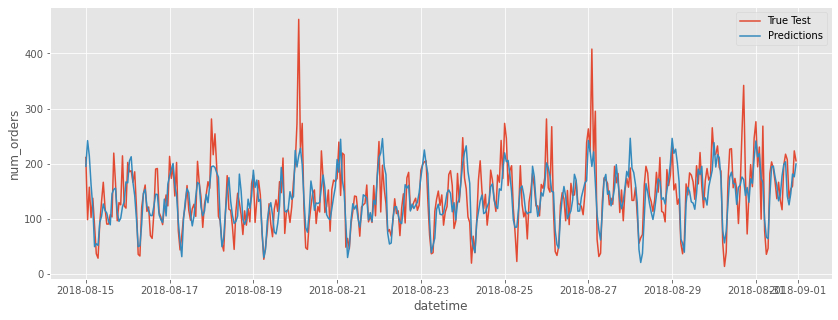

In [29]:
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
data = df_preds['2018-08-15':]
sns.lineplot(x=data.index, y=data['num_orders'], label='True Test')
sns.lineplot(x=data.index, y=data['preds'], label='Predictions')

### Вывод
Модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Редки пики в данных (Рост спроса на такси по выходным) предсказать не может. 

# Общий вывод

- Линейные модели показали похожий результат по RMSE.
- Максимальное смещение ограничено значением 100 ввиду сложности модели. Дальше показатель RMSE не сильно растёт.
- Наилучшие результат даёт скользящее окно размером 1 час на примере модели Lasso, это значение хорошо сглаживает кривую тренда, судя по графику.
- С помощью модели Lasso удалось уменьшить RMSE на 59,5 % относительно baseline.
- По графику видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Однако редкие пики в данных  предсказать не может.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48